### 180508N
### EN2550_Assignment5
### Object Counting on a Convey Belt

### 1.0.1 Let’s first import required librarie

In [1]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def Drowimage(img1,img2):
    fig, ax = plt. subplots(1,2,figsize=(10,10))
    ax[0].imshow(img1, cmap='gray')
    ax[1].imshow(img2, cmap='gray')
    plt.show()
    return

In [3]:
 def Drowimage_one(img):   
    fig, ax = plt. subplots(1,1,figsize=(10,10))
    ax.imshow(img, cmap='gray')
    plt.show()
    return

### 1.0.2 Let’s load and visualize the template image and the convey belt snapshot at a given time.

In [4]:
#Lode data from google driver
template_im = cv.imread(r'template.png', cv.IMREAD_GRAYSCALE)
belt_im = cv.imread(r'belt.png', cv.IMREAD_GRAYSCALE)

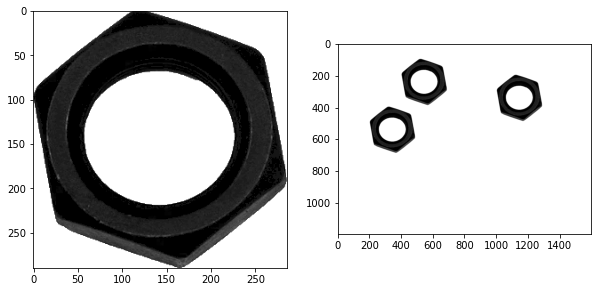

In [5]:
Drowimage(template_im,belt_im)

## 1.1 Part-I :
Before going into the implementation, let’s play with some functions.
### 1.1.1 Otsu’s thresholding
Please read thresholding to get an idea about different types of thresholding and how to use
them.(Please use cv.THRESH_BINARY_INV)

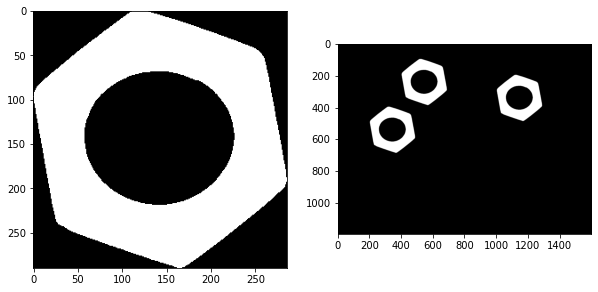

In [6]:
th_t, img_t = cv.threshold(template_im,0,255,cv.THRESH_BINARY_INV+cv.THRESH_OTSU)
th_b, img_b = cv.threshold(belt_im,0,255,cv.THRESH_BINARY_INV+cv.THRESH_OTSU)
Drowimage(img_t,img_b)

### 1.1.2 Morphological closing
Carry out morphological closing to remove small holes inside the foreground. Use a 3 × 3 kernel.
See closing for a guide.

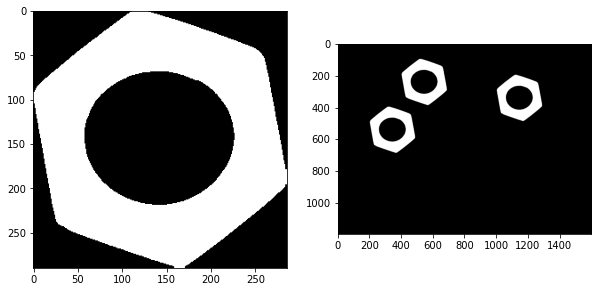

In [7]:
kernel = np.ones((3,3),np.uint8)
closing_t = cv.morphologyEx(img_t, cv.MORPH_CLOSE, kernel)
closing_b = cv.morphologyEx(img_b, cv.MORPH_CLOSE, kernel)
Drowimage(closing_t,closing_b)

### 1.1.3 Connected component analysis
Apply the connectedComponentsWithStats function (see this).

In [8]:
retval_t, labels_t, stats_t, centroids_t = cv.connectedComponentsWithStats(closing_t)
retval_b, labels_b, stats_b, centroids_b = cv.connectedComponentsWithStats(closing_b)

print("Number of components template : ",retval_t)
print("Number of components belt : ",retval_b)
print(" ")
print("Stats template : \n",stats_t )
print("Stats belt : \n",stats_b )
print(" ")
print("Centroids template : \n",centroids_t )
print("Centroids belt : \n",centroids_b )

Number of components template :  2
Number of components belt :  4
 
Stats template : 
 [[    0     0   286   290 42290]
 [    0     0   286   290 40650]]
Stats belt : 
 [[      0       0    1600    1200 1798161]
 [    400     100     286     290   40613]
 [   1000     200     286     290   40613]
 [    200     400     286     290   40613]]
 
Centroids template : 
 [[142.18770395 145.19172381]
 [142.82489545 143.780369  ]]
Centroids belt : 
 [[ 807.85728475  614.56805258]
 [ 542.82567158  243.78479797]
 [1142.82567158  343.78479797]
 [ 342.82567158  543.78479797]]


###   1.1.4 Contour analysis
<p>Use findContours function to retrieve the extreme outer contours. (see for help and see for
information.) </p>
Display these countours.

In [9]:
contours_t, hierarchy_t = cv.findContours(closing_t, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
contours_b, hierarchy_b = cv.findContours(closing_b, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)

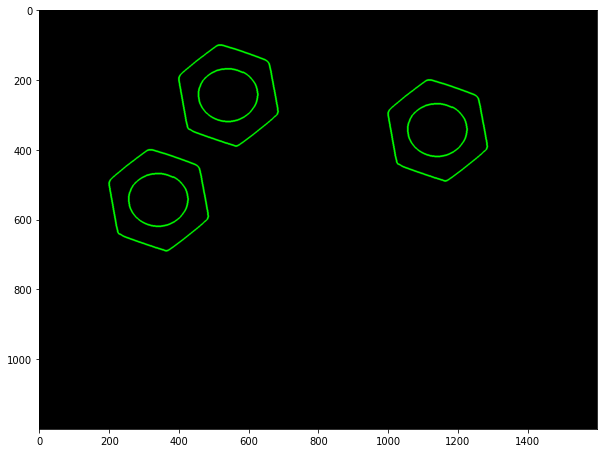

In [10]:
im_contours_belt = np.zeros((belt_im.shape[0],belt_im.shape[1],3), np.uint8)
conts = cv.drawContours(im_contours_belt, contours_b, -1, (0,255,0), 3).astype('uint8')
Drowimage_one(conts)

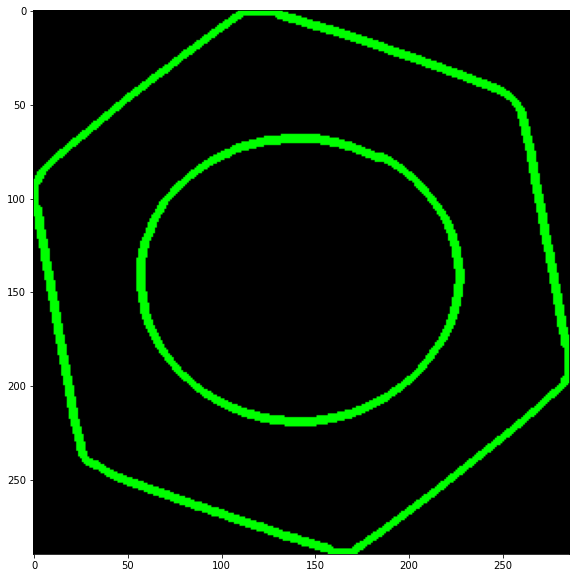

In [11]:
im_contours_belt = np.zeros((template_im.shape[0],template_im.shape[1],3), np.uint8)
conts = cv.drawContours(im_contours_belt, contours_t, -1, (0,255,0), 3).astype('uint8')
Drowimage_one(conts)

### 1.1.5 Count the number of matching hexagonal nuts in belt.png.
<p>Use the matchShapes function as shown in examples to match contours in the belt image with that
    in the template.</p>
Get an idea about the value output by the cv.matchShapes when both the template and the
reference image have the same shape. Understand the given code snippet.


In [12]:
label = 1 # remember that the label of the background is 0
belt = ((labels_b >= label)*255).astype('uint8')
belt_cont, template_hierarchy = cv.findContours(belt, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
for j,c in enumerate(belt_cont):
  print(cv.matchShapes(contours_t[0], c, cv.CONTOURS_MATCH_I1, 0.0))


0.00010071698397173812
0.00010071698397950968
0.00010071698397506879


## 1.2 Part - II
### 1.2.1 Frame tracking through image moments.
Use the cv.contourArea(), see this and calculate the the area of the contours_b[1]

In [13]:
ca = cv.contourArea(contours_b[1])
print("Area of the contours belt: ",ca)

Area of the contours belt:  20080.0


Use the cv.moments to extract the x and y coordinates of the centroid of contours_b[1].

In [14]:
M = cv.moments(contours_b[1])
cx, cy = int(M['m10']/M['m00']), int(M['m01']/M['m00']) 
print("Centroid coordinates", (cx, cy))

Centroid coordinates (341, 542)


<p>Make a variable called count to represent the number of contours and set it to the value 1. Make
an np array [cx, cy, ca, count] and name this as object_prev_frame</p><p>Similarly, you can create the object_curr_frame(to describe the current values) and define the
threshold delta_x to check whether the corresponding element of both the object_curr_frame
and object_prev_frame are less than the delta_x. You can set delta_x as 15 or so. (Here the
delta_x can be thought of as the movement of the cx from frame to frame)</p>

In [15]:
count = 1
object_prev_frame = np.array([cx, cy, ca, count])
delta_x = 15

## 1.3 Part - III
### 1.3.1 1. Implement the function get_indexed_image, which takes an image as the input, performs thresholding, closing, and connected component analysis and return retval, labels, stats, centroids. (Grading)

In [16]:
def get_indexed_image(im):
  th, img = cv.threshold(im,0,255,cv.THRESH_BINARY_INV+cv.THRESH_OTSU)
  kernel = np.ones((3,3),np.uint8)
  closing = cv.morphologyEx(img, cv.MORPH_CLOSE, kernel)
  retval, labels, stats, centroids = cv.connectedComponentsWithStats(closing)
  return retval, labels, stats, centroids

### 1.3.1 1. Implement the function is_new, which checks the dissimilarity between vectors. (Grading)


In [17]:
 def is_new(a, b, delta, i):
   for j in range(len(a)):
     k = abs(a[j][i] - b[i])
     if k < delta:
       return False
       break
   else:
     return True


In [18]:
 # check is_new expected answer False
a = np.array([[1.36100e+03, 5.53000e+02, 5.99245e+04, 2.00000e+00],
[7.61000e+02, 4.53000e+02, 5.99385e+04, 1.00000e+00],
[1.55200e+03, 2.43000e+02, 6.00585e+04, 3.00000e+00]])
b = np.array([7.51000e+02, 4.53000e+02, 5.99385e+04, 3.00000e+00])
delta = np.array([delta_x])
i = np.array([0])
assert is_new(a, b, delta, i) == False, " Check the function "

 **1.3.3 3. If the array a is in the shape of (number of nuts , len(object_prev_frame))
( i.e. array a is made by stacking all the object_prev_frame for each frame. If
b is in the form of [cx, cy, ca, count], write the function prev_index to find the
index of a particular nut in the previous frame. (Grading) bold text**


In [19]:
 def prev_index(a, b, delta, i):
   index = -1
   for j in range(len(a)):
     k = abs(a[j][i] - b[i])
     if k < delta:
       return j
   else:
     return index

In [20]:
 # check prev_index expected answer 1
a = np.array([[1.36100e+03, 5.53000e+02, 5.99245e+04, 2.00000e+00],
[7.61000e+02, 4.53000e+02, 5.99385e+04, 1.00000e+00],
[1.55200e+03, 2.43000e+02, 6.00585e+04, 3.00000e+00]])
b = np.array([7.51000e+02, 4.53000e+02, 5.99385e+04, 3.00000e+00])
delta = np.array([delta_x])
i = np.array([0])
assert prev_index(a,b,delta,i) == 1, " Check the function "


**Implement a code to detect hexagonal nuts in a moving convey belt. (Grading)**

In [21]:
cap = cv.VideoCapture('conveyor_with_rotation.mp4') # give the correct path here
while cap.isOpened():
  ret, frame = cap.read()
  if not ret:
    print("Can't receive frame (stream end?). Exiting ...")
    break
  
  gray = cv.cvtColor(frame, cv.COLOR_BGR2GRAY) #converting the frame from color to grayscale
  retval, labels, stats, centroids=get_indexed_image(gray) #Get indexed image
  
  belt = ((labels >= 1)*255).astype('uint8')
  belt_cont, template_hierarchy = cv.findContours(belt, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE) #Find contours of all nuts present in a given frame 
  im_contours_belt = np.zeros((frame.shape[0],frame.shape[1],3), np.uint8)                        
  conts = cv.drawContours(im_contours_belt, belt_cont, -1, (0,255,0), 3).astype('uint8')  #Draw each contour        
  cv.namedWindow("frame", cv.WINDOW_NORMAL) 
  cv.imshow("frame",conts)                                                                        # showing the contours
  if cv.waitKey(1) == ord('q'):
        break
cap.release()
cv.destroyAllWindows()


Can't receive frame (stream end?). Exiting ...


### 1.5 Object detection and tracking

In [22]:
retval_t, labels_t, stats_t, centroids_t = get_indexed_image(template_im)
belt_t = ((labels_t >= 1)*255).astype('uint8')
belt_t_cont, template_t_hierarchy = cv.findContours(belt_t, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

a=np.array([])                         
delta = 15   
frame_num=0                                                                           

cap = cv.VideoCapture('conveyor_with_rotation.mp4')
out = cv.VideoWriter('180508n.mp4', -1 , 30.0, (1920,1080))

while cap.isOpened():
    ret, frame = cap.read() 
    frame_num+=1            
    indent=0                
    if not ret:
        print("Can't receive frame (stream end?). Exiting ...")
        break

    gray=cv.cvtColor(frame, cv.COLOR_BGR2GRAY)                                                      
    retval, labels, stats, centroids=get_indexed_image(gray)                                        
    belt = ((labels >= 1)*255).astype('uint8')
    belt_cont, template_hierarchy = cv.findContours(belt, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE) 
    im_contours_belt = np.zeros((frame.shape[0],frame.shape[1],3), np.uint8) 

 
    for cont in belt_cont:
        text="" 
        if cv.matchShapes(belt_t_cont[0], cont, cv.CONTOURS_MATCH_I1, 0.0)>0.0008:
            continue
        
        ca = cv.contourArea(cont)
        M = cv.moments(cont)
        if M['m00']==0:
            continue
        cx, cy = int(M['m10']/M['m00']) , int(M['m01']/M['m00'])
        count = 1 
        object_curr_frame = np.array([cx, cy, ca, count])


        if a.shape[0]==0:       
            a=(np.append(a,object_curr_frame)).reshape((1,4))
            index=a.shape[0]-1  

        elif is_new(a, object_curr_frame, delta, 0):                    
            a=np.concatenate((a,np.array([object_curr_frame])),axis=0)  
            index=a.shape[0]-1                                          
        else:
            index=prev_index(a, object_curr_frame, delta, 0)   
            a[index]=object_curr_frame                         

        font = cv.FONT_HERSHEY_SIMPLEX
        cv.putText(im_contours_belt,str(index+1),(cx,cy), font, 2,(255,0,255),2,cv.LINE_AA)
        text+="Object "+str(index+1)+" "+str(a[index,0])+", "+str(a[index,1])+", "+str(a[index,2])
        cv.putText(im_contours_belt,text,(50,1050-indent), font, 1.5,(255,0,255),2,cv.LINE_AA)
        indent+=50 
        
    
    cv.putText(im_contours_belt,"Frame "+str(frame_num),(50,1050-indent), font, 1.5,(0,255,0),2,cv.LINE_AA) 
    cv.putText(im_contours_belt,"Index Num : "+str(180508)+"N",(50,50), font, 1.5,(255,255,255),2,cv.LINE_AA)
    
    conts = cv.drawContours(im_contours_belt, belt_cont, -1, (0,255,0), 3).astype('uint8')                              
    cv.namedWindow("frame", cv.WINDOW_NORMAL) 
    cv.imshow("frame",conts)
    out.write(conts)
     
    if cv.waitKey(1) == ord('q'):
        break
cap.release()
out.release()
cv.destroyAllWindows()

Can't receive frame (stream end?). Exiting ...
